##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial will show you how to build a basic speech recognition network that recognizes ten different words. It's important to know that real speech and audio recognition systems are much more complex, but like MNIST for images, it should give you a basic understanding of the techniques involved. Once you've completed this tutorial, you'll have a model that tries to classify a one second audio clip as "down", "go", "left", "no", "right", "stop", "up" and "yes".

## Setup

Import necessary modules and dependencies.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license.

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

    16384/182082353 [..............................] - ETA: 0s

  4202496/182082353 [..............................] - ETA: 3s

 24371200/182082353 [===>..........................] - ETA: 0s

 36421632/182082353 [=====>........................] - ETA: 0s

 50339840/182082353 [=======>......................] - ETA: 1s

 56287232/182082353 [========>.....................] - ETA: 1s

 62586880/182082353 [=========>....................] - ETA: 1s

 75694080/182082353 [===========>..................] - ETA: 0s

 92758016/182082353 [==============>...............] - ETA: 0s

109060096/182082353 [================>.............] - ETA: 0s

129343488/182082353 [====================>.........] - ETA: 0s

149397504/182082353 [=======================>......] - ETA: 0s

169992192/182082353 [===========================>..] - ETA: 0s

182083584/182082353 [==============================] - 1s 0us/step


182091776/182082353 [==============================] - 1s 0us/step


Check basic statistics about the dataset.

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'yes' 'left' 'right' 'up' 'stop' 'go' 'down']


Extract the audio files into a list and shuffle it.

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/a8e25ebb_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

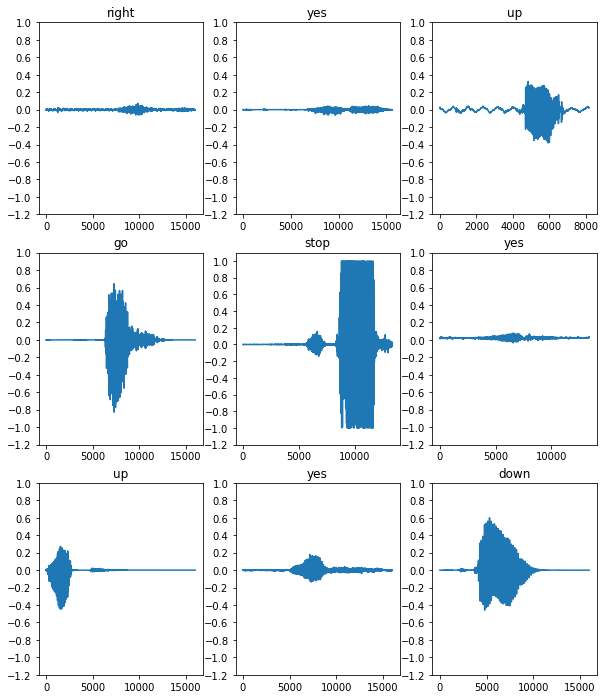

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [12]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


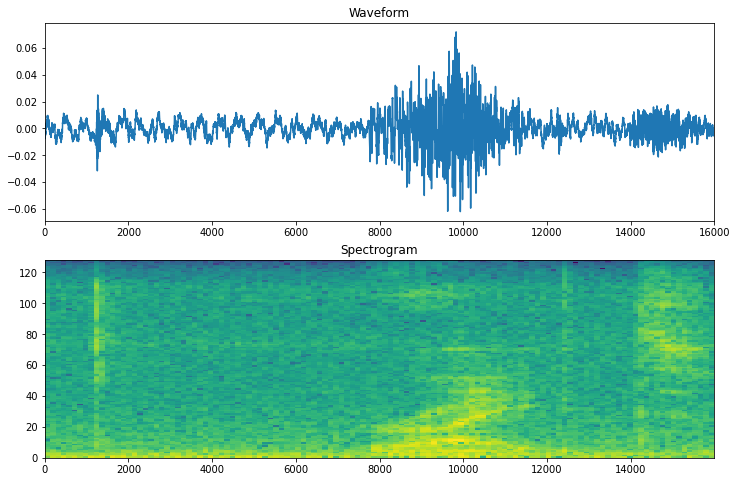

In [14]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [15]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [16]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


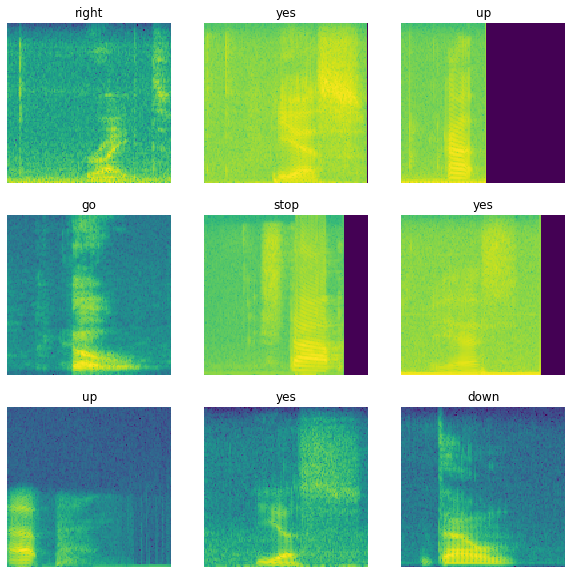

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [18]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [20]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


  1/100 [..............................] - ETA: 15:24 - loss: 2.1870 - accuracy: 0.1094

  5/100 [>.............................] - ETA: 1s - loss: 2.1163 - accuracy: 0.1437   

  7/100 [=>............................] - ETA: 2s - loss: 2.1079 - accuracy: 0.1585

  9/100 [=>............................] - ETA: 2s - loss: 2.0915 - accuracy: 0.1753

 11/100 [==>...........................] - ETA: 2s - loss: 2.0784 - accuracy: 0.1818

 13/100 [==>...........................] - ETA: 2s - loss: 2.0671 - accuracy: 0.1899

 15/100 [===>..........................] - ETA: 2s - loss: 2.0545 - accuracy: 0.1990

 17/100 [====>.........................] - ETA: 2s - loss: 2.0471 - accuracy: 0.2169

 19/100 [====>.........................] - ETA: 2s - loss: 2.0448 - accuracy: 0.2171

 21/100 [=====>........................] - ETA: 2s - loss: 2.0376 - accuracy: 0.2225

 23/100 [=====>........................] - ETA: 2s - loss: 2.0352 - accuracy: 0.2242

 25/100 [======>.......................] - ETA: 2s - loss: 2.0282 - accuracy: 0.2262

 27/100 [=======>......................] - ETA: 2s - loss: 2.0181 - accuracy: 0.2332

 29/100 [=======>......................] - ETA: 2s - loss: 2.0097 - accuracy: 0.2381

 31/100 [========>.....................] - ETA: 2s - loss: 2.0009 - accuracy: 0.2460

 33/100 [========>.....................] - ETA: 2s - loss: 1.9906 - accuracy: 0.2500

 35/100 [=========>....................] - ETA: 2s - loss: 1.9808 - accuracy: 0.2545

 37/100 [==========>...................] - ETA: 2s - loss: 1.9728 - accuracy: 0.2597

 39/100 [==========>...................] - ETA: 1s - loss: 1.9590 - accuracy: 0.2688

 41/100 [===========>..................] - ETA: 1s - loss: 1.9493 - accuracy: 0.2721

 43/100 [===========>..................] - ETA: 1s - loss: 1.9443 - accuracy: 0.2740

 45/100 [============>.................] - ETA: 1s - loss: 1.9309 - accuracy: 0.2809

 47/100 [=============>................] - ETA: 1s - loss: 1.9215 - accuracy: 0.2876

 49/100 [=============>................] - ETA: 1s - loss: 1.9130 - accuracy: 0.2915

 51/100 [==============>...............] - ETA: 1s - loss: 1.9085 - accuracy: 0.2923

 53/100 [==============>...............] - ETA: 1s - loss: 1.9006 - accuracy: 0.2972

 55/100 [===============>..............] - ETA: 1s - loss: 1.8977 - accuracy: 0.2980

 57/100 [================>.............] - ETA: 1s - loss: 1.8914 - accuracy: 0.3010

 59/100 [================>.............] - ETA: 1s - loss: 1.8854 - accuracy: 0.3030

 61/100 [=================>............] - ETA: 1s - loss: 1.8768 - accuracy: 0.3081

 63/100 [=================>............] - ETA: 1s - loss: 1.8706 - accuracy: 0.3105

 65/100 [==================>...........] - ETA: 1s - loss: 1.8627 - accuracy: 0.3125

 67/100 [===================>..........] - ETA: 1s - loss: 1.8542 - accuracy: 0.3172

 69/100 [===================>..........] - ETA: 1s - loss: 1.8486 - accuracy: 0.3209

 71/100 [====================>.........] - ETA: 0s - loss: 1.8423 - accuracy: 0.3244

 73/100 [====================>.........] - ETA: 0s - loss: 1.8355 - accuracy: 0.3286

 75/100 [=====================>........] - ETA: 0s - loss: 1.8339 - accuracy: 0.3306

 77/100 [======================>.......] - ETA: 0s - loss: 1.8249 - accuracy: 0.3352

 79/100 [======================>.......] - ETA: 0s - loss: 1.8201 - accuracy: 0.3364

 81/100 [=======================>......] - ETA: 0s - loss: 1.8126 - accuracy: 0.3416

 83/100 [=======================>......] - ETA: 0s - loss: 1.8058 - accuracy: 0.3445

 85/100 [========================>.....] - ETA: 0s - loss: 1.7980 - accuracy: 0.3469

 87/100 [=========================>....] - ETA: 0s - loss: 1.7914 - accuracy: 0.3490

 89/100 [=========================>....] - ETA: 0s - loss: 1.7845 - accuracy: 0.3509

 91/100 [==========================>...] - ETA: 0s - loss: 1.7800 - accuracy: 0.3527

 93/100 [==========================>...] - ETA: 0s - loss: 1.7727 - accuracy: 0.3557

 95/100 [===========================>..] - ETA: 0s - loss: 1.7659 - accuracy: 0.3584

 97/100 [============================>.] - ETA: 0s - loss: 1.7608 - accuracy: 0.3608

 99/100 [============================>.] - ETA: 0s - loss: 1.7526 - accuracy: 0.3651

100/100 [==============================] - 13s 40ms/step - loss: 1.7503 - accuracy: 0.3659 - val_loss: 1.3361 - val_accuracy: 0.5600


Epoch 2/10
  1/100 [..............................] - ETA: 0s - loss: 1.3641 - accuracy: 0.5781

 16/100 [===>..........................] - ETA: 0s - loss: 1.3249 - accuracy: 0.5439

 31/100 [========>.....................] - ETA: 0s - loss: 1.3154 - accuracy: 0.5333

 46/100 [============>.................] - ETA: 0s - loss: 1.2820 - accuracy: 0.5530

 61/100 [=================>............] - ETA: 0s - loss: 1.2668 - accuracy: 0.5597

 76/100 [=====================>........] - ETA: 0s - loss: 1.2386 - accuracy: 0.5691

 91/100 [==========================>...] - ETA: 0s - loss: 1.2109 - accuracy: 0.5776

100/100 [==============================] - 0s 4ms/step - loss: 1.1948 - accuracy: 0.5809 - val_loss: 0.9340 - val_accuracy: 0.7225


Epoch 3/10
  1/100 [..............................] - ETA: 0s - loss: 0.9889 - accuracy: 0.7188

 16/100 [===>..........................] - ETA: 0s - loss: 0.9481 - accuracy: 0.6729

 32/100 [========>.....................] - ETA: 0s - loss: 0.9885 - accuracy: 0.6611

 47/100 [=============>................] - ETA: 0s - loss: 0.9563 - accuracy: 0.6729

 63/100 [=================>............] - ETA: 0s - loss: 0.9647 - accuracy: 0.6617

 79/100 [======================>.......] - ETA: 0s - loss: 0.9432 - accuracy: 0.6713

 95/100 [===========================>..] - ETA: 0s - loss: 0.9284 - accuracy: 0.6773

100/100 [==============================] - 0s 4ms/step - loss: 0.9253 - accuracy: 0.6773 - val_loss: 0.7738 - val_accuracy: 0.7588


Epoch 4/10
  1/100 [..............................] - ETA: 0s - loss: 0.5785 - accuracy: 0.7812

 16/100 [===>..........................] - ETA: 0s - loss: 0.7566 - accuracy: 0.7129

 32/100 [========>.....................] - ETA: 0s - loss: 0.7801 - accuracy: 0.7134

 48/100 [=============>................] - ETA: 0s - loss: 0.7609 - accuracy: 0.7256

 63/100 [=================>............] - ETA: 0s - loss: 0.7742 - accuracy: 0.7242

 79/100 [======================>.......] - ETA: 0s - loss: 0.7613 - accuracy: 0.7300

 95/100 [===========================>..] - ETA: 0s - loss: 0.7578 - accuracy: 0.7322

100/100 [==============================] - 0s 4ms/step - loss: 0.7543 - accuracy: 0.7341 - val_loss: 0.6993 - val_accuracy: 0.7650


Epoch 5/10
  1/100 [..............................] - ETA: 0s - loss: 0.6389 - accuracy: 0.7969

 17/100 [====>.........................] - ETA: 0s - loss: 0.6515 - accuracy: 0.7574

 33/100 [========>.....................] - ETA: 0s - loss: 0.6431 - accuracy: 0.7652

 49/100 [=============>................] - ETA: 0s - loss: 0.6364 - accuracy: 0.7685

 65/100 [==================>...........] - ETA: 0s - loss: 0.6584 - accuracy: 0.7635

 81/100 [=======================>......] - ETA: 0s - loss: 0.6554 - accuracy: 0.7672

 97/100 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.7724

100/100 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.7719 - val_loss: 0.6500 - val_accuracy: 0.7800


Epoch 6/10
  1/100 [..............................] - ETA: 0s - loss: 0.3641 - accuracy: 0.8750

 17/100 [====>.........................] - ETA: 0s - loss: 0.5591 - accuracy: 0.7969

 33/100 [========>.....................] - ETA: 0s - loss: 0.5662 - accuracy: 0.7988

 49/100 [=============>................] - ETA: 0s - loss: 0.5652 - accuracy: 0.8026

 65/100 [==================>...........] - ETA: 0s - loss: 0.5809 - accuracy: 0.7947

 80/100 [=======================>......] - ETA: 0s - loss: 0.5782 - accuracy: 0.7953

 96/100 [===========================>..] - ETA: 0s - loss: 0.5739 - accuracy: 0.7980

100/100 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.7977 - val_loss: 0.6049 - val_accuracy: 0.7975


Epoch 7/10
  1/100 [..............................] - ETA: 0s - loss: 0.3789 - accuracy: 0.8594

 17/100 [====>.........................] - ETA: 0s - loss: 0.4933 - accuracy: 0.8199

 33/100 [========>.....................] - ETA: 0s - loss: 0.5158 - accuracy: 0.8163

 49/100 [=============>................] - ETA: 0s - loss: 0.5112 - accuracy: 0.8154

 66/100 [==================>...........] - ETA: 0s - loss: 0.5250 - accuracy: 0.8123

 81/100 [=======================>......] - ETA: 0s - loss: 0.5231 - accuracy: 0.8131

 96/100 [===========================>..] - ETA: 0s - loss: 0.5156 - accuracy: 0.8161

100/100 [==============================] - 0s 4ms/step - loss: 0.5181 - accuracy: 0.8155 - val_loss: 0.5967 - val_accuracy: 0.8200


Epoch 8/10
  1/100 [..............................] - ETA: 0s - loss: 0.3330 - accuracy: 0.8594

 16/100 [===>..........................] - ETA: 0s - loss: 0.4230 - accuracy: 0.8545

 31/100 [========>.....................] - ETA: 0s - loss: 0.4311 - accuracy: 0.8493

 46/100 [============>.................] - ETA: 0s - loss: 0.4355 - accuracy: 0.8461

 61/100 [=================>............] - ETA: 0s - loss: 0.4451 - accuracy: 0.8414

 77/100 [======================>.......] - ETA: 0s - loss: 0.4485 - accuracy: 0.8409

 92/100 [==========================>...] - ETA: 0s - loss: 0.4497 - accuracy: 0.8404

100/100 [==============================] - 0s 4ms/step - loss: 0.4493 - accuracy: 0.8402 - val_loss: 0.5678 - val_accuracy: 0.8100


Epoch 9/10
  1/100 [..............................] - ETA: 0s - loss: 0.2855 - accuracy: 0.8750

 15/100 [===>..........................] - ETA: 0s - loss: 0.4172 - accuracy: 0.8531

 30/100 [========>.....................] - ETA: 0s - loss: 0.4218 - accuracy: 0.8552

 46/100 [============>.................] - ETA: 0s - loss: 0.4331 - accuracy: 0.8485

 61/100 [=================>............] - ETA: 0s - loss: 0.4371 - accuracy: 0.8458

 77/100 [======================>.......] - ETA: 0s - loss: 0.4364 - accuracy: 0.8460

 92/100 [==========================>...] - ETA: 0s - loss: 0.4316 - accuracy: 0.8480

100/100 [==============================] - 0s 4ms/step - loss: 0.4292 - accuracy: 0.8491 - val_loss: 0.5531 - val_accuracy: 0.8175


Epoch 10/10
  1/100 [..............................] - ETA: 0s - loss: 0.3186 - accuracy: 0.8750

 16/100 [===>..........................] - ETA: 0s - loss: 0.3993 - accuracy: 0.8535

 31/100 [========>.....................] - ETA: 0s - loss: 0.3966 - accuracy: 0.8604

 46/100 [============>.................] - ETA: 0s - loss: 0.3861 - accuracy: 0.8584

 61/100 [=================>............] - ETA: 0s - loss: 0.3920 - accuracy: 0.8584

 77/100 [======================>.......] - ETA: 0s - loss: 0.3943 - accuracy: 0.8584

 92/100 [==========================>...] - ETA: 0s - loss: 0.3933 - accuracy: 0.8592

100/100 [==============================] - 0s 4ms/step - loss: 0.3914 - accuracy: 0.8598 - val_loss: 0.5204 - val_accuracy: 0.8275


Let's check the training and validation loss curves to see how your model has improved during training.

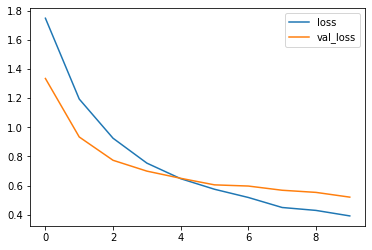

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

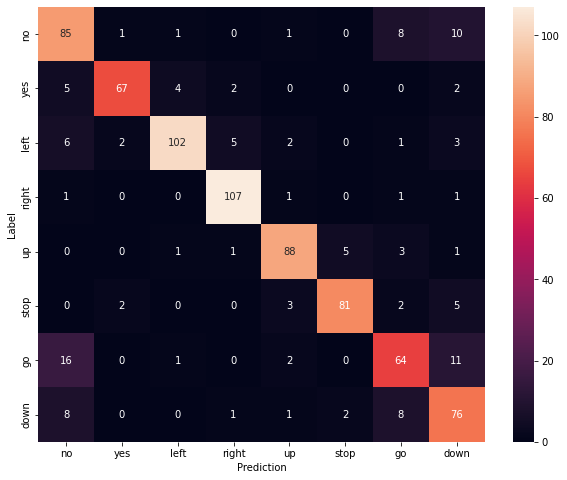

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

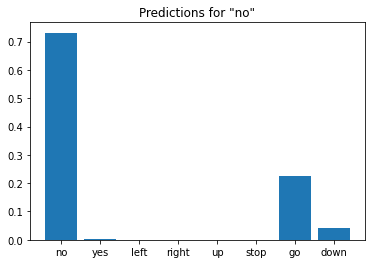

In [29]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

You can see that your model very clearly recognized the audio command as "no."

## Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
